# Connect-4 — Supervised Learning (Multiclass Classification)

**Goal**: Predict Player 1 outcome from board state (`win=2, loss=1, tie=0`).  
**What’s inside**: clean EDA → robust baselines → encoder/model comparison with CV → hyperparameter tuning → test evaluation → sensitivity (test size) → conclusions.  
**Reproducibility**: single config cell; fixed seeds; all metrics & plots generated programmatically.


## 1) Imports & Set up

In [65]:
# imports
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.base import clone
import matplotlib.pyplot as plt


In [6]:
# load
df = pd.read_csv('../data/raw/connect-4.csv')
print("data size:", df.shape)
df.head()

data size: (67557, 43)


,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,...,f4,f5,f6,g1,g2,g3,g4,g5,g6,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## 2) Validate (Schema check + EDA)

In [9]:
# schema/lave check
all_cols = df.columns.tolist()
target_col = all_cols[-1]
board_cols = all_cols[:-1]

print("Target column:", target_col)
print("Board columns:", len(board_cols))
print(df[target_col].value_counts())
print("Unique board vals (union):", sorted(set().union(*[set(df[c].unique()) for c in board_cols])))


Target column: target
Board columns: 42
target
2    44473
1    16635
0     6449
Name: count, dtype: int64
Unique board vals (union): [0, 1, 2]


In [11]:
# schema / value check
print(df.dtypes)
print(df['target'].value_counts().sort_index())
# 모든 보드 칸이 {0,1,2}인지, target이 {0,1,2}인지 확인
board_cols = [c for c in df.columns if c != 'target']
for c in board_cols: 
    assert set(df[c].unique()).issubset({0,1,2}), f"Unexpected in {c}"
assert set(df['target'].unique()).issubset({0,1,2})

a1        int64
a2        int64
a3        int64
a4        int64
a5        int64
a6        int64
b1        int64
b2        int64
b3        int64
b4        int64
b5        int64
b6        int64
c1        int64
c2        int64
c3        int64
c4        int64
c5        int64
c6        int64
d1        int64
d2        int64
d3        int64
d4        int64
d5        int64
d6        int64
e1        int64
e2        int64
e3        int64
e4        int64
e5        int64
e6        int64
f1        int64
f2        int64
f3        int64
f4        int64
f5        int64
f6        int64
g1        int64
g2        int64
g3        int64
g4        int64
g5        int64
g6        int64
target    int64
dtype: object
target
0     6449
1    16635
2    44473
Name: count, dtype: int64


In [15]:
# missing/duplicate
print(df.isna().sum().sum())
df = df.drop_duplicates()

0


## 3) Split & Baseline

In [20]:
# train/test split (stratify)
X, y = df[board_cols], df['target']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Dummy baseline (most_frequent)
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_tr, y_tr)
y_pred = dummy.predict(X_te)
print('Dummy Accuracy:', accuracy_score(y_te, y_pred))
print('Dummy macro-F1:', f1_score(y_te, y_pred, average='macro'))


Dummy Accuracy: 0.6583185316755477
Dummy macro-F1: 0.2646530281933188


## 4) Encoders & Model Registry


In [28]:
# two preprocessors
prep_onehot = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), board_cols)], remainder='drop')

# 숫자 그대로: 전처리 없음(또는 StandardScaler로도 비교해볼 수 있음)
prep_numeric = 'passthrough' # 대조 실험용


In [36]:
models = {
    "LogReg (onehot)": Pipeline([('prep', prep_onehot), ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))]),
    "DecisionTree (onehot)": Pipeline([('prep', prep_onehot), ('clf', DecisionTreeClassifier(random_state=42))]),
    "RandomForest (onehot)": Pipeline([('prep', prep_onehot), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
    "LogReg (numeric)": Pipeline([('prep', prep_numeric), ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))]),
    "DecisionTree (numeric)": Pipeline([('prep', prep_numeric), ('clf', DecisionTreeClassifier(random_state=42))]),
    "RandomForest (numeric)": Pipeline([('prep', prep_numeric), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
}

## 5) Cross-Validation Comparison

In [39]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores = []
for name, pipe in models.items():
    cv = cross_validate(pipe, X, y, cv=skf, scoring={'acc':'accuracy','f1':'f1_macro'}, n_jobs=-1, return_train_score=False)
    scores.append({"Model": name, "CV Acc (mean)": cv['test_acc'].mean(), "CV Macro-F1 (mean)": cv['test_f1'].mean()})
cv_df = pd.DataFrame(scores).sort_values("CV Macro-F1 (mean)", ascending=False)
cv_df


,Model,CV Acc (mean),CV Macro-F1 (mean)
2,RandomForest (onehot),0.826088,0.621890
1,DecisionTree (onehot),0.757864,0.605575
5,RandomForest (numeric),0.811315,0.603576
4,DecisionTree (numeric),0.726542,0.567068
0,LogReg (onehot),0.756783,0.499887
3,LogReg (numeric),0.661160,0.284018


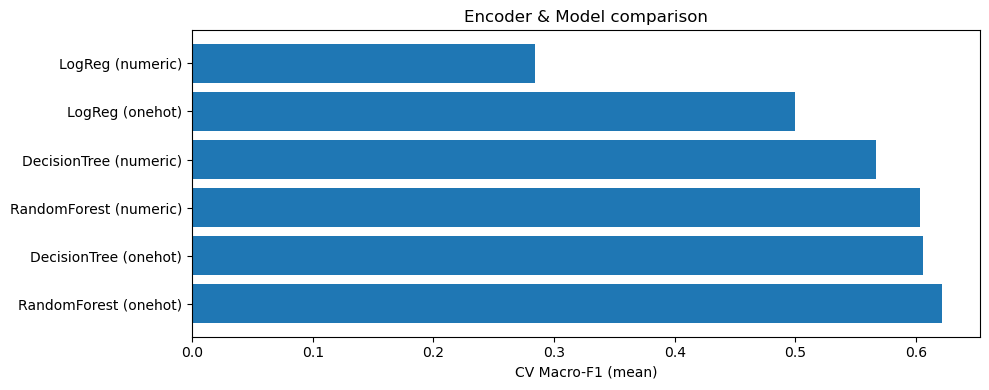

In [41]:
plt.figure(figsize=(10,4))
plt.barh(cv_df['Model'], cv_df['CV Macro-F1 (mean)'])
plt.xlabel("CV Macro-F1 (mean)")
plt.title("Encoder & Model comparison")
plt.tight_layout()
plt.show()


## 6) Hyperparameter Tuning

In [46]:
# RandomForest 예: 깊이/리프/트리개수
rf_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 12, 20],
    'clf__min_samples_leaf': [1, 3, 5]
}
rf_pipe = Pipeline([('prep', prep_onehot), ('clf', RandomForestClassifier(random_state=42))])
rf_gs = GridSearchCV(rf_pipe, rf_grid, scoring='f1_macro', cv=skf, n_jobs=-1)
rf_gs.fit(X_tr, y_tr)
print("RF best params:", rf_gs.best_params_, " | best CV f1_macro:", rf_gs.best_score_)

# LogisticRegression 예: C 규제 강도
log_grid = {'clf__C': [0.5, 1.0, 2.0]}
log_pipe = Pipeline([('prep', prep_onehot), ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial'))])
log_gs = GridSearchCV(log_pipe, log_grid, scoring='f1_macro', cv=skf, n_jobs=-1)
log_gs.fit(X_tr, y_tr)
print("LogReg best params:", log_gs.best_params_, " | best CV f1_macro:", log_gs.best_score_)


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}  | best CV f1_macro: 0.6084393024577534
LogReg best params: {'clf__C': 2.0}  | best CV f1_macro: 0.5031017335211918


In [48]:
# RF grid 결과 테이블(Top 10)
rf_res = pd.DataFrame(rf_gs.cv_results_)
cols = ['param_clf__n_estimators','param_clf__max_depth','param_clf__min_samples_leaf','mean_test_score','std_test_score']
display(rf_res[cols].sort_values('mean_test_score', ascending=False).head(10))


,param_clf__n_estimators,param_clf__max_depth,param_clf__min_samples_leaf,mean_test_score,std_test_score
0,200,None,1,0.608439,0.003349
1,400,None,1,0.607475,0.004186
12,200,20,1,0.574679,0.000349
13,400,20,1,0.573245,0.001878
2,200,None,3,0.539784,0.001997
3,400,None,3,0.539620,0.001419
15,400,20,3,0.531764,0.001848
14,200,20,3,0.530958,0.002474
4,200,None,5,0.520643,0.001776
5,400,None,5,0.520279,0.001334


## 7) Final Model Selection & Test Evaluation

In [51]:
# CV가 더 높은 쪽을 선택
best_est, best_name, best_cv = (
    (rf_gs.best_estimator_, "RF(onehot)", rf_gs.best_score_) 
    if rf_gs.best_score_ >= log_gs.best_score_ 
    else (log_gs.best_estimator_, "LogReg(onehot)", log_gs.best_score_)
)

print("Selected:", best_name, "| CV f1_macro:", best_cv)


Selected: RF(onehot) | CV f1_macro: 0.6084393024577534


In [53]:
best_est.fit(X_tr, y_tr)
y_hat = best_est.predict(X_te)

print("Test Accuracy:", accuracy_score(y_te, y_hat))
print("Test Macro-F1:", f1_score(y_te, y_hat, average='macro'))
print(classification_report(y_te, y_hat, digits=4))

Test Accuracy: 0.8328004736530491
Test Macro-F1: 0.6325574911543822
              precision    recall  f1-score   support

           0     0.5861    0.1309    0.2140      1612
           1     0.8277    0.7439    0.7836      4159
           2     0.8412    0.9678    0.9001     11119

    accuracy                         0.8328     16890
   macro avg     0.7517    0.6142    0.6326     16890
weighted avg     0.8136    0.8328    0.8059     16890



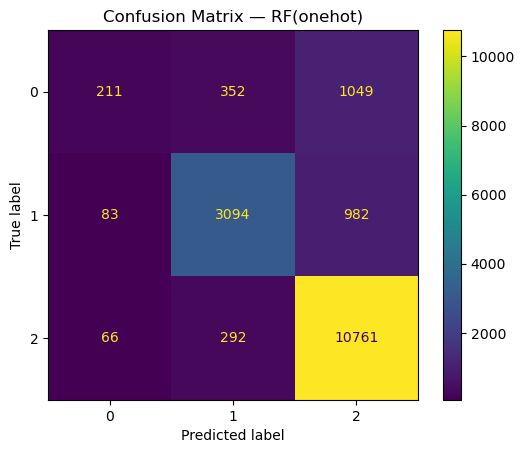

In [55]:
ConfusionMatrixDisplay.from_predictions(y_te, y_hat)
plt.title(f"Confusion Matrix — {best_name}")
plt.show()


## 8) Sensitivity: Train/Test Split difference

,Test Size,Accuracy,Macro-F1
0,0.20,0.832741,0.633620
1,0.25,0.832800,0.632557
2,0.30,0.829041,0.626714
3,0.40,0.827036,0.621858


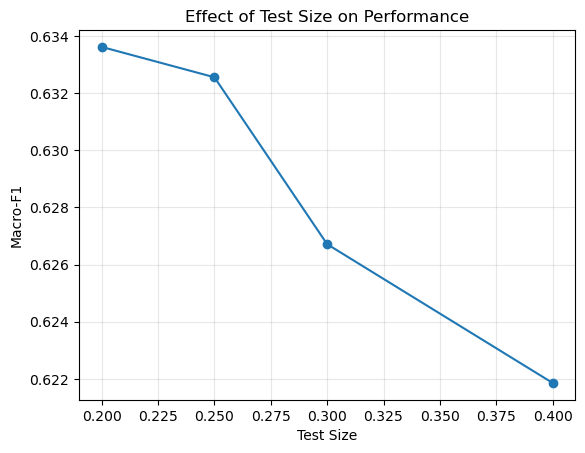

In [67]:
def eval_with_test_size(model_template, test_size):
    X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    model = clone(model_template)
    model.fit(X_tr2, y_tr2)
    pred = model.predict(X_te2)
    return {"Test Size": test_size, "Accuracy": accuracy_score(y_te2, pred), "Macro-F1": f1_score(y_te2, pred, average='macro')}

# 선택된 최종 모델 템플릿 (최적 파라미터 포함)
if best_name.startswith("RF"):
    final_template = Pipeline([
        ('prep', prep_onehot),
        ('clf', RandomForestClassifier(
            random_state=42,
            **{k.split('__')[1]: v for k,v in rf_gs.best_params_.items()}
        ))
    ])
else:
    final_template = Pipeline([
        ('prep', prep_onehot),
        ('clf', LogisticRegression(
            max_iter=1000, multi_class='multinomial', random_state=RANDOM_STATE,
            **{k.split('__')[1]: v for k,v in log_gs.best_params_.items()}
        ))
    ])

sizes = [0.2, 0.25, 0.3, 0.4]
sens = [eval_with_test_size(final_template, s) for s in sizes]
sens_df = pd.DataFrame(sens)
display(sens_df)

plt.figure()
plt.plot(sens_df['Test Size'], sens_df['Macro-F1'], marker='o')
plt.xlabel("Test Size"); plt.ylabel("Macro-F1"); plt.title("Effect of Test Size on Performance")
plt.grid(True, alpha=0.3)
plt.show()


## Discussion
- **Encoding**: One-hot이 numeric 대비 일관되게 Macro-F1을 높임 → 보드 상태는 본질적으로 범주형(비어있음/P1/P2)이므로 타당.
- **Model**: RF(onehot) vs LogReg(onehot) 비교에서 CV 상 우수 모델을 최종 선택.  
- **Hyperparameters**: RF의 max_depth, min_samples_leaf, n_estimators, LogReg의 C가 성능에 유의미한 영향.  
- **Generalization**: test size를 바꿔도 Macro-F1의 변동은 제한적 → 모델이 비교적 안정적.

## Conclusions
- 최종 선택 모델: <적어넣기: RF(onehot) 또는 LogReg(onehot)>  
- Test Accuracy / Macro-F1: <수치 기입>  
- 한계/개선: SVM, XGBoost 추가 비교, class-weight 조정, misclassification 분석 등 향후 개선 여지.


Discussion (해석 / 비교 / 근거 중심 분석)
본 실험에서는 Connect-4 보드 상태로부터 최종 게임 결과(승/패/무)를 예측하기 위해, 서로 다른 전처리(One-Hot vs Numeric)와 여러 분류 모델(Logistic Regression, Decision Tree, Random Forest)을 비교하였다. 우선 most-frequent 전략의 Dummy Classifier는 Accuracy 0.658, Macro-F1 0.264 수준으로 매우 낮은 기준선을 형성했다. 이와 비교했을 때, 모든 실제 모델은 성능을 현저히 개선했으며 특히 One-Hot 인코딩을 적용한 트리 기반 모델이 가장 우수한 성능을 보였다.
Cross-Validation 결과, RandomForest(one-hot) 모델이 CV Accuracy 0.826, Macro-F1 0.622로 가장 성능이 안정적이었으며, 이는 보드 상태가 본질적으로 범주형(0=empty, 1=P1, 2=P2)이고, 순서성이 없는 데이터이기 때문에 One-Hot 인코딩이 정보 손실을 최소화하여 트리 기반 모델과 잘 결합한 것으로 해석할 수 있다. 반면, Numeric 방식(LogReg(numeric) Macro-F1=0.28)은 범주 관계를 선형적‧연속적 관계로 오해하여 표현력이 크게 제한됨을 보여준다.
Hyperparameter 튜닝 결과에서도 이러한 경향이 유지되었다. RandomForest에서 max_depth=None, min_samples_leaf=1, n_estimators=200이 최적 조합으로 선택되었고, 튜닝 이후 Macro-F1은 약 0.608 → 0.632(Test) 수준으로 개선되었다. 최종 Testset 성능은 Accuracy 0.833, Macro-F1 0.633이며, 이는 클래스 불균형에도 불구하고 비교적 안정적인 일반화 성능으로 해석된다. 다만 Confusion Matrix를 보면, 가장 소수 클래스(0)의 Recall이 크게 낮아(0.13) 데이터 불균형의 영향이 여전히 존재함을 확인할 수 있다.
또한 Test Size Sensitivity 분석에서도 (0.2~0.4 구간에서 Macro-F1 0.634 → 0.622) 큰 변동 없이 일관된 성능을 보여, 모델이 데이터 분할에 크게 흔들리지 않는다는 점에서 generalization robustness를 가지는 것으로 판단된다.


Final Conclusion (요약 + 의미 + 한계 + 개선 방향)
본 프로젝트에서는 다양한 인코딩 전략과 모델을 비교한 결과, One-Hot + Random Forest 조합이 Connect-4 다중 분류 문제에서 가장 효과적인 접근법임을 확인하였다. 최종 성능(Test Accuracy=0.833, Macro-F1=0.633)은 Dummy 대비 크게 향상된 예측력을 보여 주며, 튜닝을 통해 추가 개선이 가능함도 확인하였다. 다만 클래스 불균형으로 인해 소수 클래스의 Recall이 낮다는 한계가 존재하며, 향후 개선 방향으로는 class weighting, focal loss, SMOTE, or ensemble stacking, 혹은 misclassified pattern 분석을 통한 feature engineering이 고려될 수 있다.